## Traffic Statistics

This notebook presents the brief overall traffic statistics. The notebook assumes you have access to a full timespan, usually a full day or a full week, of prediction results from which at least a subset of vehicles have an associated groundtruth. Gaining an understanding of traffic statistics can be very useful. 

The next code cells show how to plot the most basic stats such as the traffic flux (vehicles per a certain duration), a piechart of overall occupancy counts (that can shed light on the skew of the natural traffic that is using the lane), and overall statistics about vehicle classes.

In [1]:
#@title Prediction Parameters { display-mode: "form" }
datetime_format = '%d/%m/%Y %H:%M:%S.%f' #@param {type:"string"}
#@markdown Prediction File Required Column Names - Enter the column names associated with the required pieces of data
date = 'Date' #@param {type:"string"}
time = 'Time' #@param {type:"string"}
front_passenger_count = 'Number of Passengers in first row (driver)' #@param {type:"string"}
rear_passenger_count = 'Number of Passengers in second row' #@param {type:"string"}
total_passenger_count = 'Total number of Passengers' #@param {type:"string"}
total_passenger_confidence = 'Confidence.1' #@param {type:"string"}
vehicle_class = 'Vehicle class'
license_plate = 'LPR' #@param {type:"string"}

In [2]:
#@title Report Generation Parameters { display-mode: "form" }
#@markdown Use 1 for an hourly plot or 24 for a daily traffic plot
traffic_plot_hours = 1 #@param [1, 24] {allow-input: false}
#@markdown Use for plot titles that rely on time periods
timely_unit_hours = "Hourly" #@param ["Hourly", "Daily"] {allow-input: true}
report_timespan = '01-01-2001' #@param {type:"date"}
vod_system_tag = 'VOD-unit-X' #@param {type:"string"}
metrics_summary_style = 'table' #@param ["table", "radar"] {allow-input: false}

In [3]:
# --------------- DO NOT EDIT THESE LINES ---------------------------
from pathlib import Path
import pandas as pd
from pandas.plotting import register_matplotlib_converters
from google.colab import files
register_matplotlib_converters()
# git clone vod-systems-performance-assessment if it does not already exist
!git -C "vod-systems-performance-assessment" pull || git clone https://gitlab.com/invisionai-public/vod-systems-performance-assessment.git
!pip install -r ./vod-systems-performance-assessment/requirements.txt
# add path to utils
import sys
sys.path.append(str(Path.cwd().joinpath('vod-systems-performance-assessment')))
# ------------ EDIT THE LINES BELOW IF NECESSARY -------------------

# requirements on the prediction file
REQUIRED_PRED_COLS = [date, time, front_passenger_count, rear_passenger_count, total_passenger_count, vehicle_class]
NUMERIC_PREDS = [front_passenger_count, rear_passenger_count, total_passenger_count]

# Report Generation Settings
DATETIME_FORMAT = datetime_format
TRAFFIC_PLOT_HOURS = traffic_plot_hours
TIMELY_UNIT_TITLE = "Hourly "
if TRAFFIC_PLOT_HOURS == 24:
    TIMELY_UNIT_TITLE = "Daily "
REPORT_TIMESPAN = report_timespan
VOD_SYSTEM_TAG = vod_system_tag
METRICS_SUMMARY_STYLE = metrics_summary_style


fatal: cannot change to 'vod-systems-performance-assessment': No such file or directory
Cloning into 'vod-systems-performance-assessment'...
remote: Enumerating objects: 354, done.
remote: Counting objects: 100% (305/305), done.
remote: Compressing objects: 100% (152/152), done.
remote: Total 354 (delta 181), reused 259 (delta 151), pack-reused 49
Receiving objects: 100% (354/354), 4.11 MiB | 22.51 MiB/s, done.
Resolving deltas: 100% (201/201), done.
Branch 'cl/add-apps-folder' set up to track remote branch 'cl/add-apps-folder' from 'origin'.
Switched to a new branch 'cl/add-apps-folder'
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 297 kB 4.2 MB/s 
     |████████████████████████████████| 180 kB 8.9 MB/s 
     |████████████████████████████████| 233 kB 10.0 MB/s 
     |████████████████████████████████| 40 kB 4.6 MB/s 
  Created wheel for Distance: filename=Distance-0.1.3-py3-none-any.whl size=16

In [4]:
# prompt for uploading the predictions and groundtruth csv files
try:
    uploaded_pred # see if already exists

except NameError:
    print('You will be prompted to enter a prediction CSV file. Select the Upload button, and then choose one file at a time.')
    print('Uploading large files may take few minutes ...\n')
    print('\nPlease Upload the Predictions CSV File')
    uploaded_pred = files.upload()

    try:
        table_pred_raw = pd.read_csv(list(uploaded_pred.keys())[0] , dtype='str')
    except:
        print('\n\nWARNING: predictions csv not uploaded completely. Using sample files instead.')
        table_pred_raw = pd.read_csv('/content/vod-systems-performance-assessment/sample-data/vehicles_FROM_07-08-2021_00-00_TO_07-08-2021_23-59_anonymized.csv', dtype='str')
    
    table_pred_raw.fillna('nan', inplace=True) # np.nan => 'nan'

# verify predictions CSV file format
assert all([col in table_pred_raw for col in REQUIRED_PRED_COLS]), "pred file does not include all required columns."
table_pred_raw[NUMERIC_PREDS] = table_pred_raw.loc[:, NUMERIC_PREDS].astype(float) # integers or nan, thus float

# convert time strings to datetime objects
table_pred_raw['Datetime'] = pd.to_datetime(table_pred_raw['Date'] + ' ' + table_pred_raw['Time'], format=DATETIME_FORMAT)

if license_plate in table_pred_raw.columns: 
  # strip the '-XYZ' country suffix in case it exists in the plate numbers
  remove_suffix = lambda x: x.split('-')[0]
  table_pred_raw[license_plate] = table_pred_raw['LPR'].apply(remove_suffix)

You will be prompted to enter a prediction CSV file. Select the Upload button, and then choose one file at a time.
Uploading large files may take few minutes ...


Please Upload the Predictions CSV File


#### Traffic Flux

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


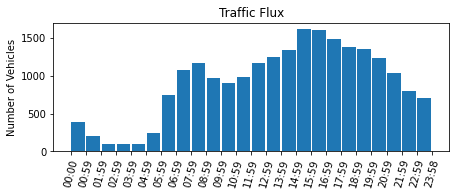

In [5]:
!mkdir -p Figures
!pip install dacite
from vod_analytics.configs import PlotConfigs
PlotConfigs.save_to_disk = True
# plotHistogram function definition in utils/plotting_utils.py
from vod_analytics.plotting import plotTimeHistoryCounts

# get timestamps and number of hours in sample
dt_pred = table_pred_raw['Datetime']
plotTimeHistoryCounts(dt_pred, TRAFFIC_PLOT_HOURS, 'Traffic Flux', 'Number of Vehicles')

#### Rush Hour Estimation

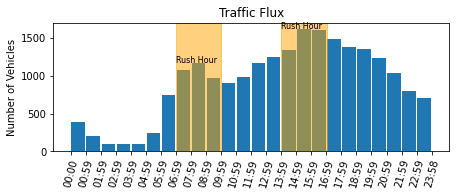

In [6]:
plotTimeHistoryCounts(dt_pred, TRAFFIC_PLOT_HOURS, 'Traffic Flux', 'Number of Vehicles', True)

#### Overall Vehicles Occupancy Distribution

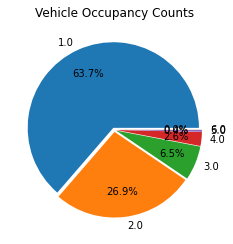

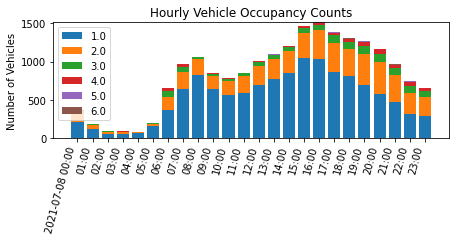

In [7]:
# get bucketed counts of occupants
table_pred_raw['occu_class'] = table_pred_raw[total_passenger_count].where(cond=table_pred_raw[total_passenger_count] > 0)

# plotPieChart function definition in utils/plotting_utils.py
from vod_analytics.plotting import plotPieChart, plotTimeHistoryStackedBars
plotPieChart(table_pred_raw['occu_class'], "Vehicle Occupancy Counts")

plotTimeHistoryStackedBars(table_pred_raw['Datetime'], table_pred_raw['occu_class'], 
                       TRAFFIC_PLOT_HOURS, TIMELY_UNIT_TITLE + "Vehicle Occupancy Counts", 'Number of Vehicles')

#### LPR Readings and Vehicle Classes

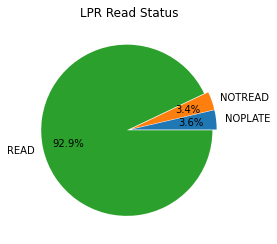

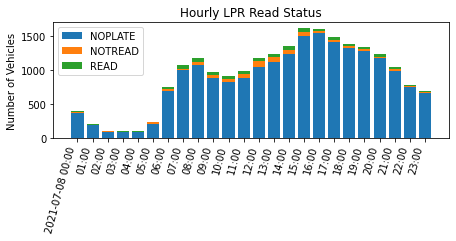

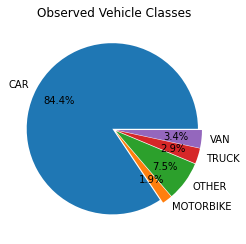

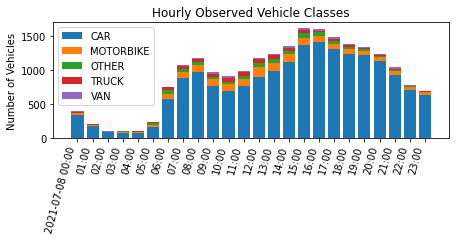

In [8]:
if 'LPR' in table_pred_raw.columns:
  # LPR reading class pie chart
  unread = pd.Series(['NOPLATE', 'NOTREAD'])
  table_pred_raw['lpr_class'] = table_pred_raw[license_plate].where(cond=table_pred_raw[license_plate].isin(unread), other='READ')
  plotPieChart(table_pred_raw['lpr_class'], 'LPR Read Status')
  plotTimeHistoryStackedBars(table_pred_raw['Datetime'], table_pred_raw['lpr_class'], TRAFFIC_PLOT_HOURS, TIMELY_UNIT_TITLE + "LPR Read Status", 'Number of Vehicles')

if vehicle_class in table_pred_raw.columns:
  # Vehicle Class pie chart
  table_pred_raw[vehicle_class].replace({'HEAVY TRUCK': 'TRUCK'}, inplace=True) # unify Heavy Truck and Truck
  table_pred_raw[vehicle_class].replace({'BUS': 'OTHER', 'UNKNOWN': 'OTHER', 'nan': 'OTHER'}, inplace=True) # unify Bus and Unknown into Other
  plotPieChart(table_pred_raw[vehicle_class], 'Observed Vehicle Classes')
  plotTimeHistoryStackedBars(table_pred_raw['Datetime'], table_pred_raw[vehicle_class], TRAFFIC_PLOT_HOURS, TIMELY_UNIT_TITLE + "Observed Vehicle Classes", 'Number of Vehicles')

## Summary PDF Report Generator

In this section, we will use the fpdf library to auto generate a summary report.

#### Code to Generate the Plots in the PDF Report (1st page)

In [9]:
!pip install fpdf2
from fpdf import FPDF
# helper functions for inserting image into pdf and adding header found in utils/pdf_utils.py
from vod_analytics.pdf import imgInPDF, addHeader
!cp /content/vod-systems-performance-assessment/Invision_Logo.png /content/Figures/Invision_Logo.png
!mkdir -p Results

# Generate First Page
pdf = FPDF()
pdf.add_page()
addHeader(pdf, f'{REPORT_TIMESPAN}, {VOD_SYSTEM_TAG}')

# traffic stats plots
pdf.set_font('Times', 'B', 20)
pdf.cell(0, 10, 'Traffic Statistics', align='C')
imgInPDF('Traffic Flux', pdf, x=30, y=35, h=60)
imgInPDF(TIMELY_UNIT_TITLE + 'Vehicle Occupancy Counts', pdf, x=30, y=105, h=80)
imgInPDF('Vehicle Occupancy Counts', pdf, x=80, y=175, h=60)

if vehicle_class in table_pred_raw.columns:
  pdf.add_page()
  addHeader(pdf, f'{REPORT_TIMESPAN}, {VOD_SYSTEM_TAG}')
  imgInPDF(TIMELY_UNIT_TITLE + 'Observed Vehicle Classes', pdf, x=30, y=35, h=80)
  imgInPDF('Observed Vehicle Classes', pdf, x=80, y=105, h=60)

pdf_file = Path.cwd().joinpath('Results', f'Traffic_Stats_{REPORT_TIMESPAN}_{VOD_SYSTEM_TAG}.pdf')
pdf.output(pdf_file, 'F')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: "dest" parameter is deprecated, unused and will soon be removed
